In [2]:
import numpy as np
import networkx as nx
import scipy.stats as stats
import matplotlib.pyplot as plt

# K-Means and Spectral Clustering Lab

In this lab we will work with two unsupervised learning algorithms, namely the $K$-means algorithm and the spectral clustering algorithm. Both of these methods are known as _clustering algorithms_ because they label each data point with a discrete label corresponding to a cluster detected in the data. 


## K-means

Let $\{x_1, \dots, x_n\}$ be a set of $n$ data points. The $K$-means algorithm aims to cluster the datapoints into $K$ clusters, where the number of clusters $K$ is an input of the algorithm. The $K$-means objective function is equal to the following,
\begin{equation} \label{eq:kmeans_objective}
\underset{(C_1, \ldots, C_K)}{\text{argmin}} \sum_{j=1}^K \sum_{i \in C_j} \|x_i - c_j\|^2, \hspace{1.5cm}(1)
\end{equation}

where $\{c_1, \ldots, c_K\}$ denote the centroids of the $K$ clusters denoted $\{C_1, \ldots, C_K\}$.This objective function is solved using an iterative algorithm, where the following two steps take part at each iteration: (i) take each instance belonging  to the dataset and assign it to the nearest centroid, and (ii)  re-calculate  the centroids  of  each of the $K$  clusters. Thus, the $K$ centroids change their location step by step until no more changes are done.




In this lab we apply the $K$-means algorithm to simulated data which is drawn from several Gaussian distributions with different means and variances. We provide you with the $\texttt{generate}$_$\texttt{data}$ function to sample this data.





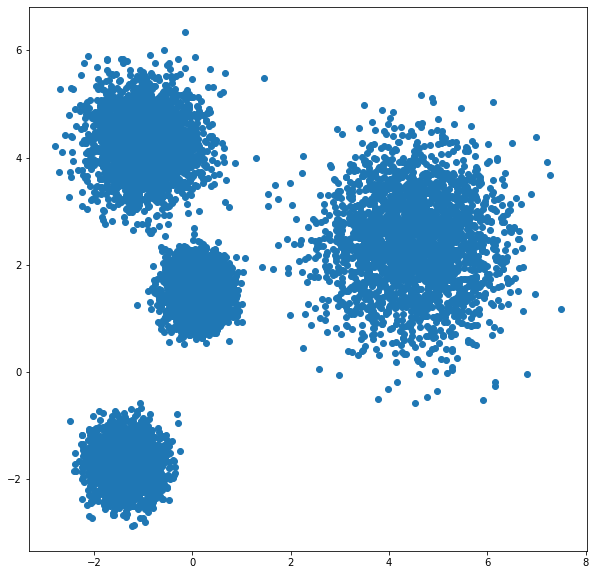

In [6]:
np.random.seed(2604)


def generate_data(n_clusters, n_dim, n_data):
    """
    Args:
        n_clusters (int): the number of clusters
        n_dim (int): data dimensionality
        n_data (int): number of data points (split evenly into clusters)
    Returns:
        X (np.array(n_data, n_dim)): data  
    """
    mus = np.random.uniform(-5, 5, size=(n_clusters,n_dim))
    sigmas = np.random.uniform(-0.7, 0.7, size=(n_clusters,n_dim))
    X = []
    for k in range(n_clusters):    
        X.append(np.random.normal(mus[k,:],sigmas[k,:] @ sigmas[k,:].T,size=(int(n_data/n_clusters),n_dim)))

    return  np.concatenate([X]).reshape(-1,n_dim)

X = generate_data(n_clusters=4, n_dim=2, n_data=10000)

plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1])
plt.show()

We will now consider two possible centroid initialisation schemes for the $K$-means algorithm. 

Firstly, in the standard $K$-means algorithm cluster centroids are initialised at random datapoints in our dataset.

Secondly, in the improved $K$-means++ algorithm the centroids are sampled one by one with the first centroid being chosen at a random data point. Further, if we let $d_i$ denote the Euclidean distance of datapoint $x_i$ to its closest, already sampled, centroid, then the probability of data point $x_i$ being chosen as the next centroid is equal to $\frac{d_i^2}{\sum_{i=1}^n d_i^2}.$ 

>**Task 1**: Implement the $K$-means++ initialisation scheme and visually compare its output with the random initialisation scheme in the below plot. (Hint: you can make use of ```np.random.multinomial``` to sample the index of the next centroid in the $K$-means++ initialisation scheme. )

In [12]:
np.min(np.array([[1,2],[4,3]]),axis = 1)

array([1, 3])

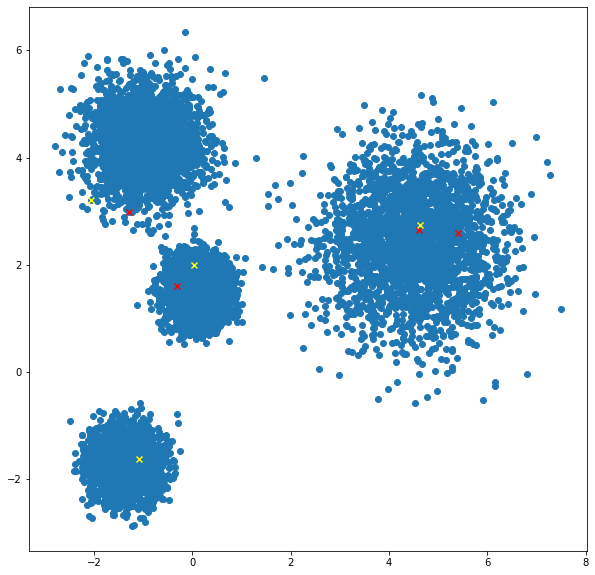

In [13]:
"""
the k means
"""
def random_initialisation(X,K):
    """
    Args:
        X (np.array): data. (N,d)
        K (int): The number of clusters
    Returns:
        c (np.array): matrix containing the sampled initial cluster centroids (K,d)
    """    
    N = X.shape[0]
    
    #initialisation
    initial_indices = np.random.choice(np.arange(N), size=K, replace=False)
    c = X[initial_indices, :]
    
    return c

"""
the k means ++
"""

def kmeans_plusplus_initialisation(X,K):
    """
    Args:
        X (np.array): data. (N,d)
        K (int): The number of clusters
    Returns:
        c (np.array): matrix containing the sampled initial cluster centroids (K,d)
    """
    N,d = X.shape
    
    c = np.zeros((K,d))
    
    initial_index = np.random.choice(np.arange(N), size=1, replace=False)
    c[0,:] = X[initial_index, :]
    
    
    # Please insert the code for Task 1 here
    distance_to_centroid = np.zeros((N,K-1))
    for k in range(K-1):
        distance_to_centroid[:,k] = np.linalg.norm(X-c[k,:],axis = 1)
        distance_to_closest_centroid = np.min(distance_to_centroid[:,:k+1],axis=1)
        sq_distance_to_closest_centroid = distance_to_closest_centroid**2

        sampling_probablity = sq_distance_to_closest_centroid/np.sum(sq_distance_to_closest_centroid)
        next_index = np.random.multinomial(1,sampling_probablity)
        c[k+1,:] = X[np.where(next_index == 1),:]
        
    return c
        
        
c_random = random_initialisation(X,4)
c_plus_plus = kmeans_plusplus_initialisation(X,4)


plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1])
plt.scatter(c_random[:,0].reshape(-1), c_random[:,1].reshape(-1), c='red', marker='x', linewidths=3)
plt.scatter(c_plus_plus[:,0].reshape(-1), c_plus_plus[:,1].reshape(-1), c='yellow', marker='x', linewidths=3)
plt.show()

>**Task 2**: Implement the $K$-means clustering algorithm.

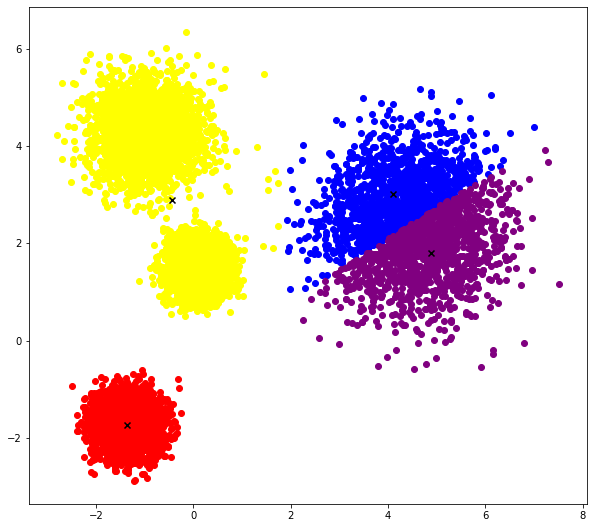

In [15]:
def K_means(X, K, initialisation, E=10**(-8)):
    """
    Args:
        X (np.array): data. (N,d)
        K (int): The number of clusters
        E (float): acceptable margin of error for the stopping rule
    Returns:
        c (np.array): matrix containing the cluster centeres means (K,d)
        S (np.array): binary matrix containing 1-hot encodings of the cluster membership (N,K)
    """
    
    
    
    if initialisation == 'random':
        c = random_initialisation(X,K)
        
    elif initialisation == 'plusplus':
        c = kmeans_plusplus_initialisation(X,K)
        
    else:
        raise ValueError("Please specify a valid initialisation scheme ('random' or 'plusplus').")
    
    N = X.shape[0]
    c_temp = c+2*E
        
    
    while(np.abs(np.mean(c-c_temp))>E):
        
        distances = np.zeros((N,K))
        for k in range(K):
            distances[:,k] = np.linalg.norm(X-c[k],axis=1)
        #step(1)
        cluster_membership = np.argmin(distances,axis=1)
        S = np.zeros((N,K))
        for i in range(N):
            S[i,cluster_membership[i]] = 1

        #step(2)
        c_temp = c
        c = S.T@X/np.sum(S,0).reshape(-1,1)
    
    return c, S

K=4
c,S = K_means(X,K, 'plusplus')

clusters_col = ["red", "blue", "yellow", "purple", "black"] 
fig, a = plt.subplots(subplot_kw={'aspect': 'equal'}, figsize=(10,10))
for j in range(K):
    x1 = [X[i,0] for i in range(X.shape[0]) if S[i,j]==1]
    x2 = [X[i,1] for i in range(X.shape[0]) if S[i,j]==1]
    a.scatter(x1,x2, c=clusters_col[j])
a.scatter(c[:,0].reshape(-1), c[:,1].reshape(-1), c='black', marker='x', linewidths=3)
plt.show()


## Spectral Clustering

We begin by briefly reviewing the spectral clustering algorithm. 

In the spectral clustering algorithm we utilise the spectral decomposition of a graph representation matrix such as the random walk Laplacian $L_{rw} = I - D^{-1}A$ to cluster a graph or network. Specifically, the spectral clustering algorithm consists of two steps. First we compute the spectral decomposition of the used graph representation matrix,
$$
L_{rw} = U \Lambda U^T.
$$
Then, in the second step we run the $k$-means algorithm on the rows of the eigenvector matrix $U_k,$ containing the eigenvectors corresponding to the $k$ smallest eigenvalues of $L_{rw},$ to cluster the nodes in our graph.

If instead of a graph we only have a set of datapoints then we are still able to use the spectral clustering algorithm by utilising one of several heuristics to infer a graph from the dataset. One such method produces a weighted *fully connected graph by using the Gaussian kernel* to represent edge weights in our inferred graph. Another is to infer a $k$*-nearest neighbours graph*, where two nodes are connected if either of them are in within the $k$ nearest neighbours of the other in Euclidean distance.



### Dataset: Three concentric circles

We begin by generating a variation of the famous synthetic, concentric circles dataset.



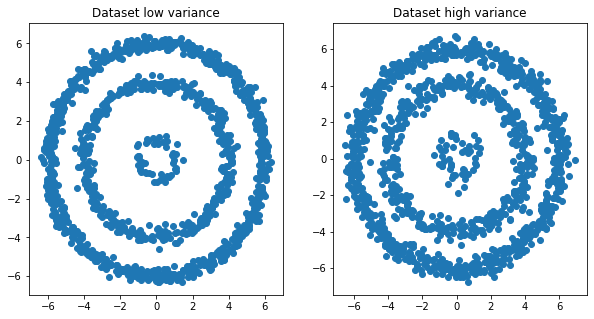

In [17]:
np.random.seed(5)

def get_circle(r=1.0, N=150):  
    # Use polar coords to get unif dist points  
    step = np.pi * 2.0 / N  
    t = np.arange(0, np.pi * 2.0, step)  
    x_1 = r * np.cos(t)  
    x_2 = r * np.sin(t)  
    return np.column_stack((x_1, x_2))
      
def get_noise(stddev=0.2, N=150):  
    # 2d gaussian random noise  
    x_1 = np.random.normal(0, stddev, N)  
    x_2 = np.random.normal(0, stddev, N)  
    return np.column_stack((x_1, x_2))    
  
def generateData(sigma):
    inner_circle = get_circle(r=1, N=50) + get_noise(sigma,N=50)
    middle_circle = get_circle(r=4, N=400) + get_noise(sigma,N=400)
    outer_circle = get_circle(r=6, N=800) + get_noise(sigma, N=800)
    return np.vstack([inner_circle, middle_circle, outer_circle])
 
 
X_low_var = generateData(0.2)

X_high_var = generateData(0.3)



# Plot data
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].scatter(X_low_var[:,0], X_low_var[:,1])
ax[0].title.set_text('Dataset low variance')
ax[1].scatter(X_high_var[:,0], X_high_var[:,1])
ax[1].title.set_text('Dataset high variance')
plt.show()

>**Task 3:** Use your $K$-means implementation to cluster the two datasets. Please store the produced labels in the two variables ```labels_low_var``` and ```labels_high_var```. You may assume knowledge of the true number of clusters, i.e., K=3.

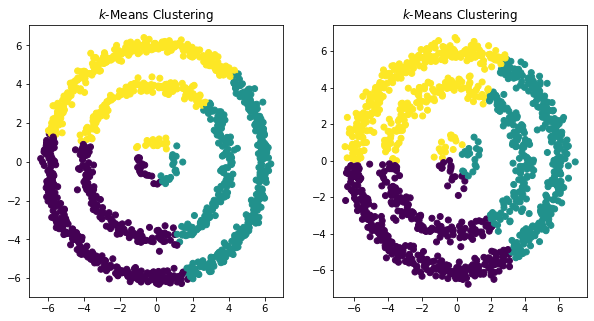

In [18]:
labels_low_var = np.zeros(X_low_var.shape[0])
labels_high_var = np.zeros(X_high_var.shape[0])

K = 3

#Please insert your code for Task 3 here
c,labels_low_var = K_means(X_low_var,K, 'plusplus')
c,labels_high_var = K_means(X_high_var,K, 'plusplus')



# Plot data
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].scatter(X_low_var[:,0], X_low_var[:,1], c=np.nonzero(labels_low_var)[1], facecolors="none") 
ax[0].title.set_text('$k$-Means Clustering')

ax[1].scatter(X_high_var[:,0], X_high_var[:,1], c=np.nonzero(labels_high_var)[1], facecolors="none") 
ax[1].title.set_text('$k$-Means Clustering')

plt.show()

We now make use of the ```knn_graph``` function to construct a k-nearest neighbour graphs from a sets of data points. We will furthermore contruct alternative graphs using the ```gaussianKernel``` function fitting a weighted fully connected graph to the data, in which edges are weighted using the gaussian kernel function $  K_{Gauss}(x_i, x_j) = \exp\left( - \frac{\| x_i - x_j\|^2}{2 \sigma^2}\right).$

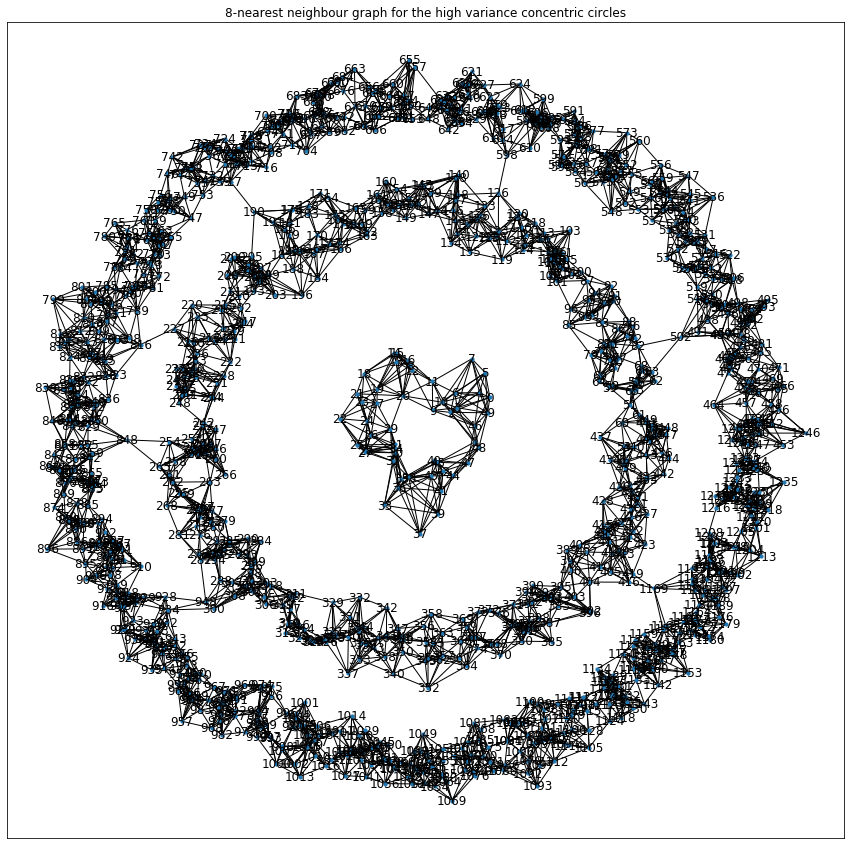

In [19]:
def knn_graph(X, neighbours):
    """
    Args:
        X (np.array, n x p):  data points
        neighbours (int): number of nearest neighbours to be considered for each node
    
    Returns:
        A (np.array, n x n): the adjacency matrix of the knn graph
    """    
    
    n = X.shape[0]
    A = np.zeros((n,n))
    
    for i in range(n):        
        distances = np.linalg.norm(X-X[i,:], axis=1)
        indices = np.argpartition(distances, neighbours+1)
        A[i, indices[:(neighbours+1)]] = 1
        A[indices[:(neighbours+1)], i] = 1
    
    A = A - np.eye(n)
    
    return A


def gaussianKernel(X1, X2, sigma = 0.1):
    """
    Args:
        X1 (np.array, n_1 x p): a set of n_1 datapoints to be used as the first of the two kernel inputs
        X2 (np.array, n_2 x p): a set of n_2 datapoints to be used as the second of the two kernel inputs
    
    Returns:
        K (np.array, n_1 x n_2): a kernel matrix containing the kernel values measuring of all possible data point pairs
    """    
    K = np.zeros((X1.shape[0],X2.shape[0]))
     
    for i in range(X1.shape[0]):
        K[i,:] = np.exp(-(np.linalg.norm(X1[i,:]-X2, axis=1)**2)/(2*sigma**2))
     
    return K


A_low_var_Gaus = gaussianKernel(X_low_var, X_low_var)
A_high_var_Gaus = gaussianKernel(X_high_var, X_high_var)


neighbours = 8
A_low_var_knn = knn_graph(X_low_var, neighbours)
A_high_var_knn =  knn_graph(X_high_var, neighbours)


    
plt.figure(1, figsize=(15,15))
G_high_var = nx.from_numpy_matrix(A_high_var_knn)
nx.draw_networkx(G_high_var, pos=X_high_var, node_size=10)
plt.title("%d-nearest neighbour graph for the high variance concentric circles" %(neighbours))
plt.show()


>**Task 4:** Implement the spectral clustering algorithm and use it to cluster the four graphs.

In [21]:
np.identity(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

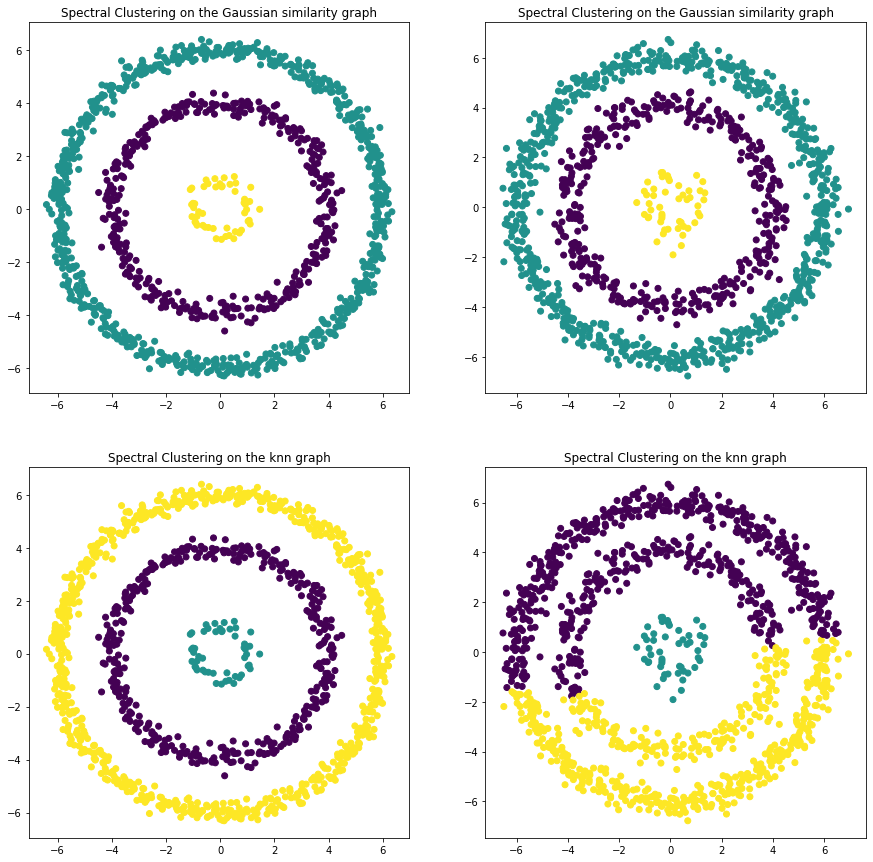

In [22]:
def spectral_clustering(A,k):
    """
    Args:
        A (np.array, n x n): the adjacency matrix of our graph
        k (int): the number of clusters
    
    Returns:
        classes (np.array, n): the inferred class labels of the n nodes
        U_k (np.array, nxk): the k eigenvectors used in the 
    """    
    #Please insert your code for Task 4 here

    #D = np.diag(np.sum(A,axis=0))
    Lrw = np.identity(A.shape[0])-np.diag(1/np.sum(A,axis=0))@A
    Lambda, U = np.linalg.eig(Lrw)
    indices = Lambda.argsort()
    U_k = np.real(U[:,indices[:k]])

    centroids, classes = K_means(U_k, k, 'plusplus')


    return classes, U_k




classes_low_var_Gaus, U_k_low_var_Gaus = spectral_clustering(A_low_var_Gaus,3)
classes_high_var_Gaus, U_k_high_var_Gaus = spectral_clustering(A_high_var_Gaus,3)

classes_low_var_knn, U_k_low_var_knn = spectral_clustering(A_low_var_knn,3)
classes_high_var_knn, U_k_high_var_knn = spectral_clustering(A_high_var_knn,3)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
ax[0,0].scatter(X_low_var[:,0], X_low_var[:,1], c=np.nonzero(classes_low_var_Gaus)[1], facecolors="none") 
ax[0,0].title.set_text('Spectral Clustering on the Gaussian similarity graph')

ax[0,1].scatter(X_high_var[:,0], X_high_var[:,1], c=np.nonzero(classes_high_var_Gaus)[1], facecolors="none") 
ax[0,1].title.set_text('Spectral Clustering on the Gaussian similarity graph')

ax[1,0].scatter(X_low_var[:,0], X_low_var[:,1], c=np.nonzero(classes_low_var_knn)[1], facecolors="none") 
ax[1,0].title.set_text('Spectral Clustering on the knn graph')

ax[1,1].scatter(X_high_var[:,0], X_high_var[:,1], c=np.nonzero(classes_high_var_knn)[1], facecolors="none") 
ax[1,1].title.set_text('Spectral Clustering on the knn graph')

plt.show()

In [28]:
test = np.linalg.eig(np.array(np.random.rand(3,3)))

In [31]:
test[0].argsort()

array([1, 2, 0])

In [32]:
test[0]

array([ 1.4662102 , -0.17760481,  0.30682897])